# Pandas 7 (Statistics)

In this lecture, we will discuss computing summary statistics about the data, going beyond the means and counts that we have mostly used so far.

* means and variances
* median and quantiles
* the describe() method
* group-wise statistics
* correlation and covariance

We will work with two different datasets

* The first is the [populations of states](https://www.census.gov/popest/data/datasets.html).
* The second is the [heights of parents and children](http://vincentarelbundock.github.io/Rdatasets/csv/HistData/Galton.csv)


### State populations from the census

In [1]:
from pandas import Series, DataFrame
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
census = pd.read_csv('Pandas_7_data/census_population.csv')
census[:5]

,SUMLEV,REGION,DIVISION,STATE,NAME,POPESTIMATE2014,POPEST18PLUS2014,PCNT_POPEST18PLUS
0,10,0,0,0,United States,318857056,245273438,76.9
1,40,3,6,1,Alabama,4849377,3741806,77.2
2,40,4,9,2,Alaska,736732,550189,74.7
3,40,4,8,4,Arizona,6731484,5109792,75.9
4,40,3,7,5,Arkansas,2966369,2259350,76.2


In [3]:
census = census.iloc[1:]  # Remove the United States from the data
state_census = census.set_index('NAME')
state_pop = state_census['POPESTIMATE2014']
state_pop[:5]

NAME
Alabama        4849377
Alaska          736732
Arizona        6731484
Arkansas       2966369
California    38802500
Name: POPESTIMATE2014, dtype: int64

### Heights of parents and children

In [4]:
heights = pd.read_csv('Pandas_7_data/Galton-Heights.csv', index_col=0)
parents = heights['parent']
heights[:5]

,parent,child
1,70.5,61.7
2,68.5,61.7
3,65.5,61.7
4,64.5,61.7
5,64.0,61.7


## Mean and Standard Deviation

Let's first just plot the histograms of state populations and parent heights.

Text(0,0.5,'Number of parents')

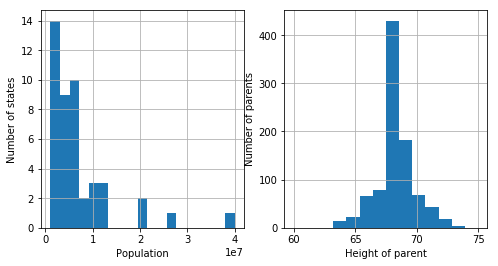

In [5]:
fig, (ax1, ax2) = subplots(nrows=1,
                           ncols=2,
                           figsize=(8, 4))

state_pop.hist(ax=ax1, bins=np.linspace(1e6, 40e6, 20))
ax1.set_xlabel('Population')
ax1.set_ylabel('Number of states')

parents.hist(ax=ax2, bins=np.linspace(60, 75, 15))
ax2.set_xlabel('Height of parent')
ax2.set_ylabel('Number of parents')

Let us first get the **means**.

In [6]:
print 'The mean state population is', state_pop.mean()
print 'The mean parent height is', parents.mean()

The mean state population is 6200104.865384615
The mean parent height is 68.30818965517241


<br />
The mean population of all the states is 6.2M. But is this a _good_ representative for state populations?

> The mean is a good representative if most states' populations are pretty close to the mean.

Is that the case here? Is it the case for heights?

One useful measure of the spread around the mean is the **standard deviation**, discussed next.

In [7]:
print 'The standard deviation of state populations is', state_pop.std()
print 'The standard deviation of parent heights is', parents.std()

The standard deviation of state populations is 7063773.816844897
The standard deviation of parent heights is 1.7873334017220202


### What does the standard deviation mean?

The meaning of the standard deviation is best seen for heights. Heights seem to closely follow the **bell curve**, also called the Normal distribution or the Gaussian distribution, which is the workhorse for all of statistics.

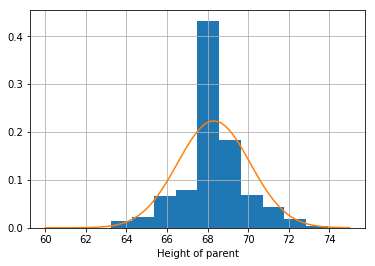

In [8]:
import scipy.stats

# We plot the histogram of parent heights 
parents.hist(bins=np.linspace(60, 75, 15), density=True)
xlabel('Height of parent')

# And a bell curve with exactly the same mean and standard deviation.
x = np.linspace(60, 75, 100)
plot(x, scipy.stats.norm.pdf(x, parents.mean(), parents.std()))

_For the bell curve,_ the standard deviation can be thought of this way (see wikipedia):

![Bell curve](http://upload.wikimedia.org/wikipedia/commons/a/a9/Empirical_Rule.PNG)

Let's see how well the parents data fits this pattern.

In [9]:
mean = parents.mean()
sd = parents.std()

mask_1_standard_dev = ((parents >= mean - sd) & (parents <= mean + sd))

print 'Fraction of parents heights within 1 standard deviation of the mean =',
print len(parents[mask_1_standard_dev]) * 1.0 / len(parents)

Fraction of parents heights within 1 standard deviation of the mean = 0.660560344828


In [10]:
# 2 standard deviations?
mask_2_standard_dev = ((parents >= mean - 2 * sd) & (parents <= mean + 2 * sd))

print 'Fraction of parents heights within 2 standard deviation of the mean =',
print len(parents[mask_2_standard_dev]) * 1.0 / len(parents)

Fraction of parents heights within 2 standard deviation of the mean = 0.935344827586


So, roughly 66% of heights fall within 1 standard deviation of the mean, and over 93% are within 2 standard deviations. We would be pretty surprised to find someone whose height is more than 3 standard deviations away.

In that sense, **parent heights are concentrated within a band around the mean height.**

<br />
What happens in the case of state populations?

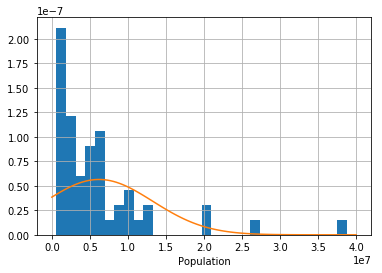

In [11]:
# Plot state populations
state_pop.hist(bins=30, density=True)
xlabel('Population')

# And a bell curve with exactly the same mean and standard deviation.
mean = state_pop.mean()
sd = state_pop.std()
x = np.linspace(0, 4e7, 100)
plot(x, scipy.stats.norm.pdf(x, mean, sd))

This doesn't look like a good fit to a bell curve; the peak is not at the mean, and there are "extreme" data points that are very far from the mean. We can also see this in the data.

In [12]:
mask_1_standard_dev = ((state_pop >= mean - sd) & (state_pop <= mean + sd))
mask_2_standard_dev = ((state_pop >= mean - 2 * sd) & (state_pop <= mean + 2 * sd))

print 'Fraction of state populations within 1 standard deviation of the mean =',
print len(state_pop[mask_1_standard_dev]) * 1.0 / len(state_pop)
print 'Fraction of state populations within 2 standard deviation of the mean =',
print len(state_pop[mask_2_standard_dev]) * 1.0 / len(state_pop)

Fraction of state populations within 1 standard deviation of the mean = 0.923076923077
Fraction of state populations within 2 standard deviation of the mean = 0.961538461538


The standard deviation is so large that over 92% of the state populations fall within 1 standard deviation of the mean. For a bell curve, we would expect only 68%.

In [13]:
most_populous_states = state_pop.sort_values(ascending=False)
most_populous_states[:5]

NAME
California    38802500
Texas         26956958
Florida       19893297
New York      19746227
Illinois      12880580
Name: POPESTIMATE2014, dtype: int64

How far away is California from the mean?

In [14]:
(most_populous_states[0] - mean ) / sd

4.615435881719321

<br />
To summarize this discussion:

* The **standard deviation** is a measure of how spread-out the data is. Greater standard deviation means the data is spread over a broader range.
* With the mean and the standard deviation in hand, we can check how well the data fits a **bell curve**.
    * Deviations from the bell curve often signal a "long tail" in the data.
    * At the very least, the data should be "handled with care"...

## Median and Quantiles

In the NFL or NBA bargaining negotations between owners and players, one often hears comments like this:

* Owners say: The mean salary of NBA players is huge, so we should not pay more.
* Players say: 50% of the players make such a small salary, so clearly owners should share more revenue.

They are both right. How?

It is similar to the state populations. We saw that the mean of the state populations was pulled to the right by just a handful of extremely populous states like California and Texas. Similarly, the mean NBA player salary gets pulled to the right by Lebron James.

The point at which the data gets split 50-50 to the left and right is called the **median**.

* In a **bell curve**, the mean is exactly the median.
* A glaring difference between mean and median is often an indication of _skew_ in the data.

In [15]:
# for parent heights
print 'Parent heights: mean =', parents.mean(), 'median =', parents.median()
print 'Relative difference =', abs(parents.mean() - parents.median()) / parents.mean()

Parent heights: mean = 68.30818965517241 median = 68.5
Relative difference = 0.002808013882315837


In [16]:
# for state populations
print 'State populations: mean =', state_pop.mean(), 'median =', state_pop.median()
print 'Relative difference =', abs(state_pop.mean() - state_pop.median()) / state_pop.mean()

State populations: mean = 6200104.865384615 median = 4191848.0
Relative difference = 0.3239069191549933


Let's plot the mean and median alongside the histogram

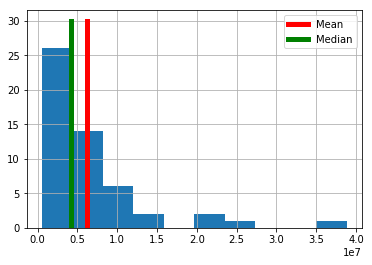

In [17]:
mean = state_pop.mean()
median = state_pop.median()

state_pop.hist(bins=10)                                                     # Histogram
plot([mean, mean], [0, 30], color='red', linewidth=5, label='Mean')         # Mean
plot([median, median], [0, 30], color='green', linewidth=5, label='Median') # Median
legend(loc='best')

For state populations, the median is almost 33% smaller than the mean. Why?

The four or five most populous states 

* have an outsized influence on the mean population,
* but they only count as a few states for the median.

Put another way,

* only the _number_ of outliers affects the median, while 
* the mean is affected by both the _number_ of outliers and their _values_.

That is why the median is **robust** against outliers.

### Quantiles

Just like the median splits the data 50-50, we can find the 25-75 or the 75-25 splits. Such splits are called quantiles.

In [18]:
print '25-percentile =', state_pop.quantile(0.25)
print 'Median = 50-percentile =', state_pop.quantile(0.5)
print '75-percentile population =', state_pop.quantile(0.75)
print '90-percentile =', state_pop.quantile(0.9)

25-percentile = 1796360.5
Median = 50-percentile = 4191848.0
75-percentile population = 6824438.5
90-percentile = 12667904.4


Let's say we want to get the 10%, 20%, ..., 90% quantiles. Instead of doing it by hand, Pandas provides the _qcut()_ function.

In [19]:
# We tell the qcut() function the Series and the number of quantiles.
out = pd.qcut(state_pop, 10)
out[:5]

NAME
Alabama         (4191848.0, 5416650.2]
Alaska          (584152.999, 861418.9]
Arizona         (6582604.1, 8815797.8]
Arkansas        (2311630.1, 3039297.8]
California    (12667904.4, 38802500.0]
Name: POPESTIMATE2014, dtype: category
Categories (10, interval[float64]): [(584152.999, 861418.9] < (861418.9, 1347983.4] < (1347983.4, 2311630.1] < (2311630.1, 3039297.8] ... (5416650.2, 6582604.1] < (6582604.1, 8815797.8] < (8815797.8, 12667904.4] < (12667904.4, 38802500.0]]

In [20]:
# If we also want to get the bins formed by the quantiles:
out, bins = pd.qcut(state_pop, 10, retbins=True)
bins

array([  584153. ,   861418.9,  1347983.4,  2311630.1,  3039297.8,
        4191848. ,  5416650.2,  6582604.1,  8815797.8, 12667904.4,
       38802500. ])

## The describe() method

Pandas combines many of the common statistics in one easy method: _describe()_.

In [21]:
state_pop.describe()

count    5.200000e+01
mean     6.200105e+06
std      7.063774e+06
min      5.841530e+05
25%      1.796360e+06
50%      4.191848e+06
75%      6.824438e+06
max      3.880250e+07
Name: POPESTIMATE2014, dtype: float64

We can get the same for all columns in a DataFrame

In [22]:
height_stats = heights.describe()
height_stats

,parent,child
count,928.000000,928.000000
mean,68.308190,68.088470
std,1.787333,2.517941
min,64.000000,61.700000
25%,67.500000,66.200000
50%,68.500000,68.200000
75%,69.500000,70.200000
max,73.000000,73.700000


We can also get descriptions for groups obtained by groupby()

In [23]:
census[:5]

,SUMLEV,REGION,DIVISION,STATE,NAME,POPESTIMATE2014,POPEST18PLUS2014,PCNT_POPEST18PLUS
1,40,3,6,1,Alabama,4849377,3741806,77.2
2,40,4,9,2,Alaska,736732,550189,74.7
3,40,4,8,4,Arizona,6731484,5109792,75.9
4,40,3,7,5,Arkansas,2966369,2259350,76.2
5,40,4,9,6,California,38802500,29649348,76.4


The regions are:

* 1 is Northeast
* 2 is Midwest
* 3 is South
* 4 is West

### Compute summary statistics of the overall population and the 18+ population for each of these regions.

Let us first create a new column with the Region Name. How?

In [24]:
census['REGION NAME'] = census['REGION'].replace({'1':'Northwest', '2':'Midwest', '3':'South', '4':'West'})
census[['POPESTIMATE2014', 'POPEST18PLUS2014', 'REGION NAME']][:5]

,POPESTIMATE2014,POPEST18PLUS2014,REGION NAME
1,4849377,3741806,South
2,736732,550189,West
3,6731484,5109792,West
4,2966369,2259350,South
5,38802500,29649348,West


In [25]:
# Just making sure we got all the regions
census['REGION NAME'].value_counts()

South        17
West         13
Midwest      12
Northwest     9
X             1
Name: REGION NAME, dtype: int64

**WOAH!** What's X?

In [26]:
census[census['REGION NAME'] == 'X']

,SUMLEV,REGION,DIVISION,STATE,NAME,POPESTIMATE2014,POPEST18PLUS2014,PCNT_POPEST18PLUS,REGION NAME
52,40,X,X,72,Puerto Rico Commonwealth,3548397,2775645,78.2,X


OK, as long as we keep this in mind...

Let's continue creating groups for each region, and running describe() on each.

In [27]:
# First, select out the columns we care about
census_pop = census[['POPESTIMATE2014', 'POPEST18PLUS2014', 'REGION NAME']]

# Do groupby(), and describe()
census_pop_statistics = census_pop.groupby('REGION NAME').describe()
census_pop_statistics

POPEST18PLUS2014                                         \
                       count          mean           std        min   
REGION NAME                                                           
Midwest                 12.0  4.336984e+06  3.145883e+06   570955.0   
Northwest                9.0  4.909333e+06  5.165357e+06   504976.0   
South                   17.0  5.394036e+06  5.177648e+06   543588.0   
West                    13.0  4.411309e+06  7.766443e+06   445830.0   
X                        1.0  2.775645e+06           NaN  2775645.0   

                                                           POPESTIMATE2014  \
                    25%        50%         75%         max           count   
REGION NAME                                                                  
Midwest      1989739.75  4316361.0  5682717.75   9892106.0            12.0   
Northwest    1059672.00  2821247.0  6926094.00  15517321.0             9.0   
South        2262810.00  3741806.0  6457174.00  19841344.0            17.0   
West         1111117.00  2038787.0  4109494.00  29649348.0            13.0   
X            2775645.00  2775645.0  2775645.00   2775645.0             1.0   

                                                                          \
                     mean           std        min        25%        50%   
REGION NAME                                                                
Midwest      5.645426e+06  4.069933e+06   739482.0  2648391.5  5607368.5   
Northwest    6.239148e+06  6.580716e+06   626562.0  1326813.0  3596677.0   
South        7.045408e+06  6.859573e+06   658893.0  2994079.0  4832482.0   
West         5.783668e+06  1.015746e+07   584153.0  1419561.0  2839099.0   
X            3.548397e+06           NaN  3548397.0  3548397.0  3548397.0   

                                    
                   75%         max  
REGION NAME                         
Midwest      7425110.5  12880580.0  
Northwest    8938175.0  19746227.0  
South        8326289.0  26956958.0  
West         5355866.0  38802500.0  
X            3548397.0   3548397.0

### Do the patterns of the 18+ population differ from the overall population among the four regions?
How do we do this?

1. For each region, compute relative differences between the statistics for the 18+ population against the overall population
2. Check if these relative differences vary a lot across the four regions

**Step 1:** Create a new column for relative differences among the statistics.

In [28]:
census_pop_statistics

POPEST18PLUS2014                                         \
                       count          mean           std        min   
REGION NAME                                                           
Midwest                 12.0  4.336984e+06  3.145883e+06   570955.0   
Northwest                9.0  4.909333e+06  5.165357e+06   504976.0   
South                   17.0  5.394036e+06  5.177648e+06   543588.0   
West                    13.0  4.411309e+06  7.766443e+06   445830.0   
X                        1.0  2.775645e+06           NaN  2775645.0   

                                                           POPESTIMATE2014  \
                    25%        50%         75%         max           count   
REGION NAME                                                                  
Midwest      1989739.75  4316361.0  5682717.75   9892106.0            12.0   
Northwest    1059672.00  2821247.0  6926094.00  15517321.0             9.0   
South        2262810.00  3741806.0  6457174.00  19841344.0            17.0   
West         1111117.00  2038787.0  4109494.00  29649348.0            13.0   
X            2775645.00  2775645.0  2775645.00   2775645.0             1.0   

                                                                          \
                     mean           std        min        25%        50%   
REGION NAME                                                                
Midwest      5.645426e+06  4.069933e+06   739482.0  2648391.5  5607368.5   
Northwest    6.239148e+06  6.580716e+06   626562.0  1326813.0  3596677.0   
South        7.045408e+06  6.859573e+06   658893.0  2994079.0  4832482.0   
West         5.783668e+06  1.015746e+07   584153.0  1419561.0  2839099.0   
X            3.548397e+06           NaN  3548397.0  3548397.0  3548397.0   

                                    
                   75%         max  
REGION NAME                         
Midwest      7425110.5  12880580.0  
Northwest    8938175.0  19746227.0  
South        8326289.0  26956958.0  
West         5355866.0  38802500.0  
X            3548397.0   3548397.0

It would be nice to have _count_, _mean_, _std_, and all those as indices. Then I can say:

> census_pop_statistics['POPEST18PLUS2014'] - census_pop_statistics['POPESTIMATE2014']

In [29]:
census_pop_stats_stacked = census_pop_statistics.stack()
census_pop_stats_stacked.loc['Midwest']

,POPEST18PLUS2014,POPESTIMATE2014
count,1.200000e+01,1.200000e+01
mean,4.336984e+06,5.645426e+06
std,3.145883e+06,4.069933e+06
min,5.709550e+05,7.394820e+05
25%,1.989740e+06,2.648392e+06
50%,4.316361e+06,5.607368e+06
75%,5.682718e+06,7.425110e+06
max,9.892106e+06,1.288058e+07


In [30]:
census_pop_stats_stacked['Relative diff'] = \
    (  census_pop_stats_stacked['POPESTIMATE2014'] \
     - census_pop_stats_stacked['POPEST18PLUS2014']) \
     / census_pop_stats_stacked['POPESTIMATE2014']
census_pop_stats_stacked.loc['Midwest':'Northwest']

POPEST18PLUS2014  POPESTIMATE2014  Relative diff
REGION NAME                                                        
Midwest     count      1.200000e+01     1.200000e+01       0.000000
            mean       4.336984e+06     5.645426e+06       0.231770
            std        3.145883e+06     4.069933e+06       0.227043
            min        5.709550e+05     7.394820e+05       0.227899
            25%        1.989740e+06     2.648392e+06       0.248699
            50%        4.316361e+06     5.607368e+06       0.230234
            75%        5.682718e+06     7.425110e+06       0.234662
            max        9.892106e+06     1.288058e+07       0.232014
Northwest   count      9.000000e+00     9.000000e+00       0.000000
            mean       4.909333e+06     6.239148e+06       0.213140
            std        5.165357e+06     6.580716e+06       0.215077
            min        5.049760e+05     6.265620e+05       0.194053
            25%        1.059672e+06     1.326813e+06       0.201340
            50%        2.821247e+06     3.596677e+06       0.215596
            75%        6.926094e+06     8.938175e+06       0.225111
            max        1.551732e+07     1.974623e+07       0.214163

**Step 2**: Check if the relative differences vary across the regions.

How should we organize the data? Ideally, we want a DataFrame

* with index being the Regions, and
* each statistic being a column

How can we get this?

(Hint: the data is currently in stacked format...)

In [31]:
stats_by_region = census_pop_stats_stacked['Relative diff'].unstack()
stats_by_region

,count,mean,std,min,25%,50%,75%,max
REGION NAME,,,,,,,,
Midwest,0.0,0.231770,0.227043,0.227899,0.248699,0.230234,0.234662,0.232014
Northwest,0.0,0.213140,0.215077,0.194053,0.201340,0.215596,0.225111,0.214163
South,0.0,0.234390,0.245194,0.174998,0.244238,0.225697,0.224484,0.263962
West,0.0,0.237282,0.235395,0.236792,0.217281,0.281889,0.232712,0.235891
X,0.0,0.217775,NaN,0.217775,0.217775,0.217775,0.217775,0.217775


All regions look roughly equal. We can confirm this by computing the standard deviation for each statistic and checking that it is pretty small compared to the mean.

But we should first drop the 'X'.

In [32]:
stats_by_region.drop('X').apply(std)

count    0.000000
mean     0.009444
std      0.011063
min      0.025039
25%      0.019479
50%      0.025687
75%      0.004503
max      0.017844
dtype: float64

With the mean being around 0.23 everywhere, the standard deviation is less than 10% of the mean. So, all regions are pretty similar in terms of population trends.

## Correlations

This is best explained by an example.

### Do tall parents have tall children? And short parents?

This is really just a way of asking: is parent height positively correlated with children's height?

In [33]:
heights['parent'].corr(heights['child'])

0.45876236829282374

What does this correlation mean?

* Correlation is a number between -1 and 1
* It measures the degree to which a _linear_ relationship holds betweeen the heights of parents and children.
    * _"Parents who are 10-inches taller have children 5-inches taller"_
        * Perfect _positive_ correlation: 1.0
    * _"Parents who are 10-inches taller have children 2-inches shorter"_
        * Perfect _negative_ correlation: -1.0
    * _"Children's height is independent of parents' heights"_
        * Zero correlation

[Wikipedia](http://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient) has good examples:

![Correlation](http://upload.wikimedia.org/wikipedia/commons/3/34/Correlation_coefficient.png)

![Another example](http://upload.wikimedia.org/wikipedia/commons/d/d4/Correlation_examples2.svg)

So how "big" is a correlation of 0.46? Roughly speaking:

Magnitude of correlation | "in English" |
----------- |:----------:|
less than 0.3 | low 
between 0.3 and 0.5 | medium 
between 0.5 and 0.9 | large 
more than 0.9 | you messed up your analysis somewhere 


<br />
This is nice, but what if my data is not quite linear?

There is another way to measure correlations based on **ranks**:

* Sort all parent heights in increasing order
* Sort all children heights in increasing order
* Are parents and their children in the same ranks in the two orderings?
    * _"Tallest parent has tallest child, second-tallest parent has second-tallest child, ..."_

This is called the Spearman coefficient, and we can compute this too.

In [34]:
heights['parent'].corr(heights['child'], method='spearman')

0.4251344659429212

The "standard" (also called Pearson) correlation was 0.46, so both types of correlations give similar answers in this case.

Consider another example: the closing prices of AAPL and the S&P 500.

In [35]:
import pandas_datareader.data as web
from datetime import datetime

start_date = datetime(2011, 1, 1) # January 1, 2011
end_date = datetime(2014, 1, 1)   # January 1, 2014

aapl = web.DataReader('AAPL', 'morningstar', start_date, end_date).loc['AAPL']
spy = web.DataReader('SPY', 'morningstar', start_date, end_date).loc['SPY']

In [36]:
stocks = DataFrame({'AAPL':aapl['Close'], 'SPY':spy['Close']})

In [37]:
print "Correlation of AAPL and S&P 500:"
print "\t Standard (Pearson):", stocks['AAPL'].corr(stocks['SPY'])
print "\t Spearman:", stocks['AAPL'].corr(stocks['SPY'], method='spearman')

Correlation of AAPL and S&P 500:
	 Standard (Pearson): 0.31733987570660727
	 Spearman: 0.49214089791228793


* Both are positive (as one might expect; AAPL is a big part of the S&P 500)
* However, Pearson and Spearman correlations are quite different
    * Possibly because the relationship isn't very linear?

Text(0,0.5,'S&P 500')

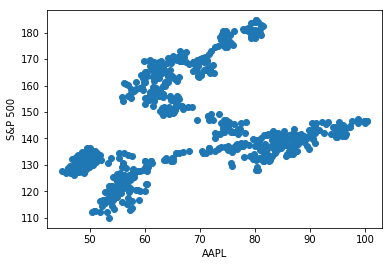

In [38]:
plot(stocks['AAPL'], stocks['SPY'], marker='o', linestyle='None')
xlabel('AAPL')
ylabel('S&P 500')

In fact, there seem to be almost two regimes.

<br />
We can also plot **rolling correlations**, i.e., correlations based on a moving time window.

In [39]:
aapl_spy_over_time = stocks['AAPL'].rolling(window=30, min_periods=10).corr(stocks['SPY'])
aapl_spy_over_time[10:20]

Date
2011-01-17    0.815077
2011-01-18    0.730201
2011-01-19    0.724176
2011-01-20    0.684825
2011-01-21    0.552831
2011-01-24    0.517240
2011-01-25    0.525540
2011-01-26    0.551656
2011-01-27    0.563517
2011-01-28    0.569450
Freq: B, dtype: float64

Let's see how the rolling correlation changes over time.

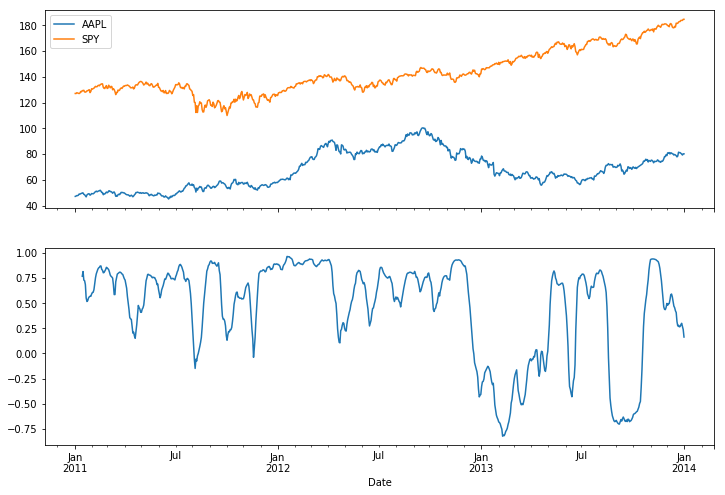

In [40]:
fig, (ax1, ax2) = subplots(nrows=2, ncols=1, sharex=True, figsize=(12, 8))

# On the first plot, show AAPL and SPY together
stocks.plot(ax=ax1, secondary_y=['S&P 500'])

# On the second plot, show the rolling correlation over time
aapl_spy_over_time.plot(ax=ax2)